In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

# Tuning the Hyperparameters

We tune the hyper-parameters of a Gaussian process using maximum marginal likelihood. See Chapter 5 of {cite:p}`10.7551/mitpress/3206.001.0001` for details.

Again, you may need to install the `gpytorch` package.

In [ ]:
!pip install gpytorch

## Example: Gaussian process regression with fitted hyperparameters

Let's generate synthetic data:

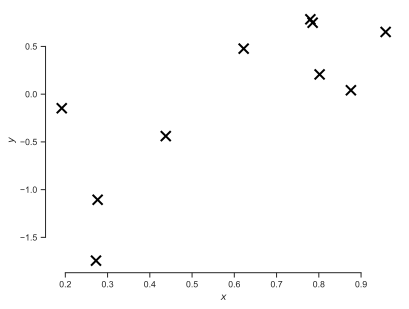

In [2]:
np.random.seed(1234)

n = 10
X = np.random.rand(n)
sigma = 0.4
f_true = lambda x: -np.cos(np.pi * x) + np.sin(4. * np.pi * x)
Y = f_true(X) + sigma * np.random.randn(X.shape[0])

fig, ax = plt.subplots()
ax.plot(X, Y, 'kx', markersize=10, markeredgewidth=2)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
sns.despine(trim=True);

We repeat some of the code from the previous section:

In [3]:
def plot_1d_regression(
    x_star,
    model,
    ax=None,
    f_true=None,
    num_samples=10
):
    """Plot the posterior predictive.
    
    Arguments
    x_start  --  The test points on which to evaluate.
    model    --  The trained model.
    
    Keyword Arguments
    ax          --  An axes object to write on.
    f_true      --  The true function.
    num_samples --  The number of samples.
    """
    f_star = model(x_star)
    m_star = f_star.mean
    v_star = f_star.variance
    y_star = model.likelihood(f_star)
    yv_star = y_star.variance

    f_lower = (
        m_star - 2.0 * torch.sqrt(v_star)
    )
    f_upper = (
        m_star + 2.0 * torch.sqrt(v_star)
    )
    
    y_lower = m_star - 2.0 * torch.sqrt(yv_star)
    y_upper = m_star + 2.0 * torch.sqrt(yv_star)

    if ax is None:
        fig, ax = plt.subplots()
    
    ax.plot(model.train_inputs[0].flatten().detach(),
            model.train_targets.detach(),
            'kx',
            markersize=10,
            markeredgewidth=2,
            label='Observations'
    )

    ax.plot(
        x_star,
        m_star.detach(),
        lw=2,
        label='$m_n(x)$',
        color=sns.color_palette()[0]
    )
    
    ax.fill_between(
        x_star.flatten().detach(),
        f_lower.flatten().detach(),
        f_upper.flatten().detach(),
        alpha=0.5,
        label='$f(\mathbf{x}^*)$ 95% pred.',
        color=sns.color_palette()[0]
    )

    ax.fill_between(
        x_star.detach().flatten(),
        y_lower.detach().flatten(),
        f_lower.detach().flatten(),
        color=sns.color_palette()[1],
        alpha=0.5,
        label='$y^*$ 95% pred.'
    )
    ax.fill_between(
        x_star.detach().flatten(),
        f_upper.detach().flatten(),
        y_upper.detach().flatten(),
        color=sns.color_palette()[1],
        alpha=0.5,
        label=None
    )

    
    if f_true is not None:
        ax.plot(
            x_star,
            f_true(x_star),
            'm-.',
            label='True function'
        )
        
    if num_samples > 0:
        f_post_samples = f_star.sample(
            sample_shape=torch.Size([10])
        )
        ax.plot(
            x_star,
            f_post_samples.T.detach(),
            color="red",
            lw=0.5
        )
        # This is just to add the legend entry
        ax.plot(
            [],
            [],
            color="red",
            lw=0.5,
            label="Posterior samples"
        )
        
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')

    plt.legend(loc='best', frameon=False)
    sns.despine(trim=True);

Let's build a Gaussian process model as usual:

In [9]:
import torch
import gpytorch
from gpytorch.kernels import RBFKernel, ScaleKernel

class ExactGP(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = ScaleKernel(RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

likelihood = gpytorch.likelihoods.GaussianLikelihood(
    noise_constraint=gpytorch.constraints.GreaterThan(0.0)
)
train_x = torch.from_numpy(X).float()
train_y = torch.from_numpy(Y).float()
model = ExactGP(train_x, train_y, likelihood)

The model has the following parameters:

+ `model.mean.constant`: the constant of the mean function.
+ `model.covar_module.outputscale`: the output scale of the kernel (variance or signal strength).
+ `model.covar_module.base_kernel.lengthscale`: the length scale of the kernel.
+ `model.likelihood.noise`: the standard deviation of the noise.

The mean constant can be any real number. The output scale, the length scale, and the noise standard deviation must be positive.
Typically, one explicitly enforces the constraints by working with a transformed version of the parameters.
For example, one works with its logarithm instead of the length scale.

GPyTorch automatically does this for us.
If you want to learn more about this, go over over [this](https://docs.gpytorch.ai/en/stable/examples/00_Basic_Usage/Hyperparameters.htmls).
GPyTorch calls the transformed parameters `raw_<NAME>`.
For example, the raw length scale is `model.covar_module.base_kernel.raw_lengthscale`.
The raw parameters are the ones that are optimized.
Here is how you can see them:

In [5]:
for name, param in model.named_parameters():
    print(f'Parameter name: {name:42} value = {param.item():1.2f}')

Parameter name: likelihood.noise_covar.raw_noise           value = 0.00
Parameter name: mean_module.raw_constant                   value = 0.00
Parameter name: covar_module.raw_outputscale               value = 0.00
Parameter name: covar_module.base_kernel.raw_lengthscale   value = 0.00


Here is now how we can maximize the marginal log likelihood:

In [10]:
# THis is necessary to initialize the model
# but it is not all we need to do
model.train()

# This is the optimizer that we will use
optimizer = torch.optim.LBFGS(model.parameters(), line_search_fn='strong_wolfe')

# This is the loss function
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# This functions runs at each iteration of the optimizer
# and it calculates the loss and its gradients
def closure():
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    return loss

# This is the training loop
n_iter = 10
for i in range(n_iter):
    loss = optimizer.step(closure)
    if (i + 1) % 1 == 0:
        print(f'Iter {i + 1:3d}/{n_iter} - Loss: {loss.item():.3f}')

# We are done training, so we can switch to eval mode
model.eval();

Iter   1/10 - Loss: 1.195
Iter   2/10 - Loss: 0.936
Iter   3/10 - Loss: 0.936
Iter   4/10 - Loss: 0.936
Iter   5/10 - Loss: 0.936
Iter   6/10 - Loss: 0.936
Iter   7/10 - Loss: 0.936
Iter   8/10 - Loss: 0.936
Iter   9/10 - Loss: 0.936
Iter  10/10 - Loss: 0.936


It is convenient to organize this into a function that we can reuse:

In [11]:
def train(model, train_x, train_y, n_iter=10, lr=0.1):
    """Train the model.

    Arguments
    model   --  The model to train.
    train_x --  The training inputs.
    train_y --  The training labels.
    n_iter  --  The number of iterations.
    """
    model.train()
    optimizer = torch.optim.LBFGS(model.parameters(), line_search_fn='strong_wolfe')
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    def closure():
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        return loss
    for i in range(n_iter):
        loss = optimizer.step(closure)
        if (i + 1) % 1 == 0:
            print(f'Iter {i + 1:3d}/{n_iter} - Loss: {loss.item():.3f}')
    model.eval()

Here are the trained parameters:

In [12]:
for name, param in model.named_parameters():
    print(f'Parameter name: {name:42} value = {param.item():1.2f}')

Parameter name: likelihood.noise_covar.raw_noise           value = -2.49
Parameter name: mean_module.raw_constant                   value = -0.04
Parameter name: covar_module.raw_outputscale               value = -0.63
Parameter name: covar_module.base_kernel.raw_lengthscale   value = -3.73


In terms of the original parameters:

In [13]:
print(f"mean constant: {model.mean_module.constant.item():.3f}")
print(f"output scale: {model.covar_module.outputscale.item():.3f}")
print(f"length scale: {model.covar_module.base_kernel.lengthscale.item():.3f}")
print(f"noise: {model.likelihood.noise.item():.3f}")

mean constant: -0.041
output scale: 0.428
length scale: 0.024
noise: 0.080


Let's plot the predictions:

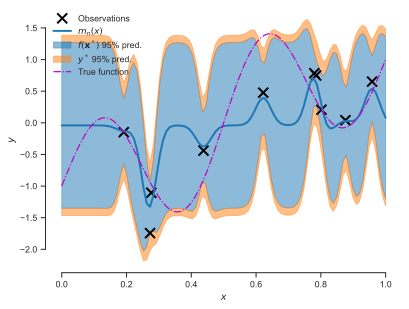

In [14]:
x_star = torch.linspace(0, 1, 100)
plot_1d_regression(x_star, model, f_true=f_true, num_samples=0)

Admittedly, this could look better.
(We can tell this only because we know the truth).
The assigned length scale is too small.
Also, the likelihood variance seems smaller than it is.
What do we do now?
You have two choices:
+ You encode some prior knowledge and repeat.
+ You add some more data and repeat.

Let's start with prior knowledge and leave the other item for the questions section.
Let's say that we know that the noise variance.
How do we encode this?
Here you go:

In [15]:
model.likelihood.noise_covar.noise = 0.1

# Verify that the change went through
print(f"noise: {model.likelihood.noise.item():.3f}")

# To make sure that the noise is not optimized, we need to do:
model.likelihood.raw_noise.requires_grad_(False);

noise: 0.100


This makes the optimizer ignore the noise parameter. Let's retrain:

In [16]:
train(model, train_x, train_y)

Iter   1/10 - Loss: 0.939
Iter   2/10 - Loss: 0.939
Iter   3/10 - Loss: 0.939
Iter   4/10 - Loss: 0.939
Iter   5/10 - Loss: 0.939
Iter   6/10 - Loss: 0.939
Iter   7/10 - Loss: 0.939
Iter   8/10 - Loss: 0.939
Iter   9/10 - Loss: 0.939
Iter  10/10 - Loss: 0.939


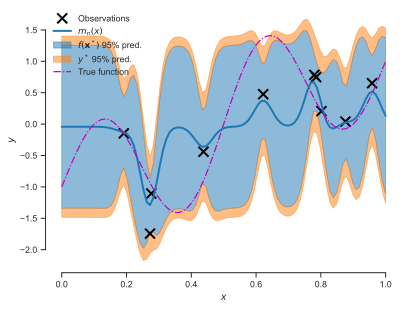

In [17]:
plot_1d_regression(x_star, model, f_true=f_true, num_samples=0)

This looks better.
But, the automatically selected length scale seems smaller than the true one.
Let's assign a prior probability density on the length scale so that it is forced to be greater.
Since we are dealing with a positive parameter and we don't know much about it, let's assign an exponential prior with a rate of 2 (which will yield an expectation of 0.5):
$$
\ell \sim \operatorname{Log-N}(0.2, 1).
$$

In [18]:
model.covar_module.register_prior(
    "lengthscale_prior",
    gpytorch.priors.LogNormalPrior(0.5, 1),
    lambda module: module.base_kernel.lengthscale
)

Let's see what difference this makes:

In [19]:
train(model, train_x, train_y)

Iter   1/10 - Loss: 1.510
Iter   2/10 - Loss: 1.226
Iter   3/10 - Loss: 1.226
Iter   4/10 - Loss: 1.226
Iter   5/10 - Loss: 1.226
Iter   6/10 - Loss: 1.226
Iter   7/10 - Loss: 1.226
Iter   8/10 - Loss: 1.226
Iter   9/10 - Loss: 1.226
Iter  10/10 - Loss: 1.226


Now here is how you can set it:

In [20]:
print(f"mean constant: {model.mean_module.constant.item():.3f}")
print(f"output scale: {model.covar_module.outputscale.item():.3f}")
print(f"length scale: {model.covar_module.base_kernel.lengthscale.item():.3f}")
print(f"noise: {model.likelihood.noise.item():.3f}")

mean constant: 0.081
output scale: 0.589
length scale: 0.111
noise: 0.100


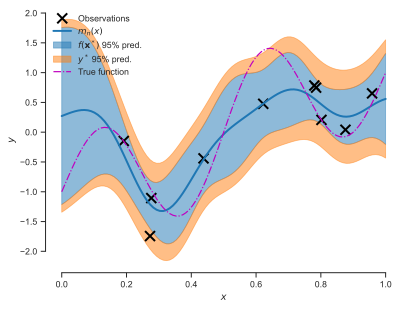

In [21]:
plot_1d_regression(x_star, model, f_true=f_true, num_samples=0)

That's better, but not perfect.
But remember: You don't know what the truth is.
There is only so much you can get without additional data.

## Questions

Let's investigate what happens to the previous examples as you increase the observations.

+ Rerun everything gradually increasing the number of samples from $n=10$ to $n=100$.
Notice that as the number of samples increases, it doesn't matter what your prior knowledge is.
As a matter of fact, for the largest number of samples you try, pick a very wrong prior probability for $\ell$.
See what happens.

+ Rerun everything with $\sigma=0.01$ (small noise) and gradually increasing the number of samples from $n=10$ to $n=100$.
For small noise, the model is trying to interpolate.
Is it capable of detecting that the noise is small when the number of observations is limited? When does the method realize the noise is indeed small?